# Evaluation of ReInspect

Evaluation for end-to-end people detection in crowded scenes.

Let's start with importing the required files, seeding the random number generators and setting up the hyperparameters.

In [108]:
%load_ext autoreload
%autoreload 2
from utils.annolist import AnnotationLib as al

import numpy as np
import matplotlib; matplotlib.use('Agg', warn=False)
import matplotlib.pyplot as plt
import logging
import argparse
import random
import json
import os
import h5py
import cv2
import time
from munkres import Munkres, print_matrix, make_cost_matrix
from scipy.misc import imread, imresize
from itertools import islice
from train import *
from utils import image_to_h5, load_data_mean, Rect
from IPython import display
%matplotlib inline

# Make sure that caffe is on the python path:
import apollocaffe
from apollocaffe.models import googlenet

config = json.load(open("config.json", 'r'))
config["solver"]["start_iter"] = 250001
config["data"]["deploy_idl"] = "/deep/u/andriluka/IMAGES/kitti/annolist_new/kitti_training_val_cars_only.pal"

random.seed(config["solver"]["random_seed"])
apollocaffe.set_random_seed(config["solver"]["random_seed"])
apollocaffe.set_device(0)
apollocaffe.set_cpp_loglevel(3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2015-08-19 15:38:24 - GPU device 0


In [109]:
data_mean = load_data_mean(config["data"]["idl_mean"], 
                           config["net"]["img_width"], 
                           config["net"]["img_height"], image_scaling=1.0)

test_gen = load_idl_list(config["data"]["test_idl"], data_mean, config["net"], True)

# images = [x.imageName for x in alfile_gen]
# h5file = [image_to_h5(imread(x), data_mean) for x in islice(images, 200)]
# h5file = [image_to_h5(imread(x), data_mean) for x in images]
# print h5file.next()
# data_list = [get_h5png(h5file) for _ in range(10)]
# data_list = zip(h5file, images)

In [110]:
net = apollocaffe.ApolloNet()
forward(net, test_gen.next(), config["net"], True)
# net.draw_to_file('/tmp/reinspect.png')
net.load("/deep/u/stewartr/snapshots/reinspect_580000.h5")

In [111]:
def filter_rects(all_rects, threshold, input_rects=[], max_threshold=1.0, config=None):
    accepted_rects = input_rects
    for i in range(0,net_config["grid_height"],1):
        for j in range(0,net_config["grid_width"],1):
            relevant_rects = []
            current_rects = [r for r in all_rects[i][j] if r.confidence > threshold]
            for other in accepted_rects:
                for current in current_rects:
                    if other.overlaps(current):
                        relevant_rects.append(other)
                        break
            if len(relevant_rects) == 0 or len(current_rects) == 0:
#             if True:
                accepted_rects += current_rects
                continue

            matrix = []
            for c in current_rects:
                row = []
                for a in relevant_rects:
                    row.append(1000)
                    if a.overlaps(c):
                        row[-1] -= 100
                    row[-1] += a.distance(c) / 1000.
                matrix.append(row)

            m = Munkres()
            cost_matrix = make_cost_matrix(matrix, lambda x: x)
            indices = m.compute(matrix)

            bad = set()
            for row, column in indices:
                c = current_rects[row]
                a = relevant_rects[column]
                if c.confidence > max_threshold:
                    bad.add(row)
                    continue
                if c.overlaps(a):
                    if c.confidence > a.confidence and c.iou(a) > 0.7:
                        # replace a with c
                        c.true_confidence = a.confidence
                        accepted_rects.remove(a)
                    else:
                        bad.add(row)

                        
            for k in range(len(current_rects)):
                if k not in bad:
                    accepted_rects.append(current_rects[k])
    return accepted_rects

We can now begin to run the model.

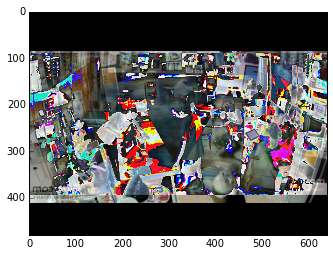

In [112]:
plt.imshow(np.transpose(net.blobs['image'].data[0], (1, 2, 0)))

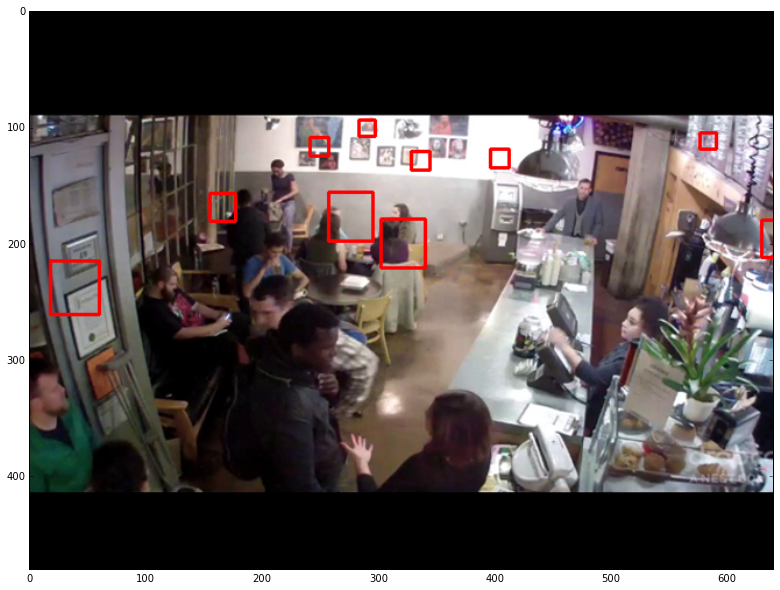

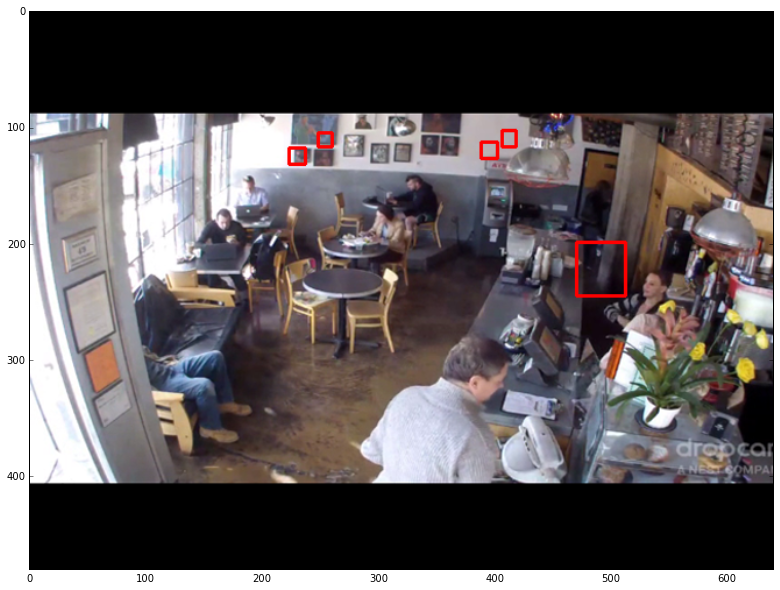

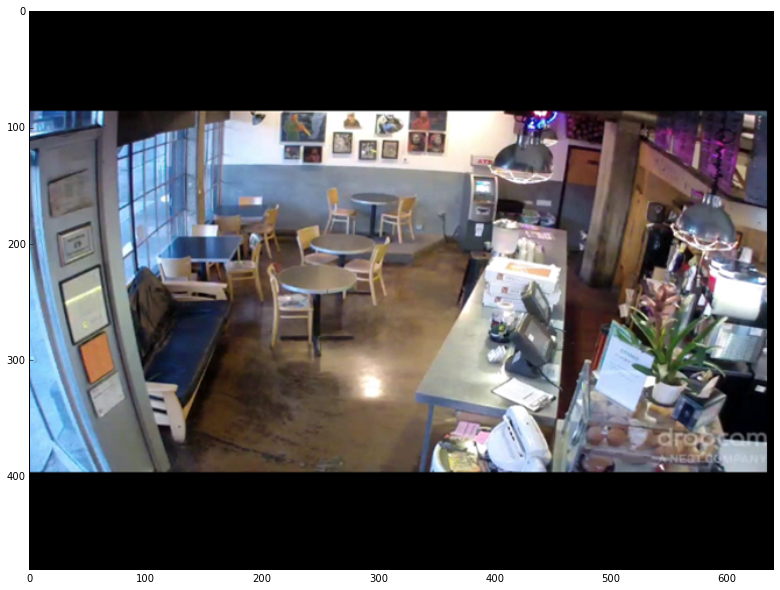

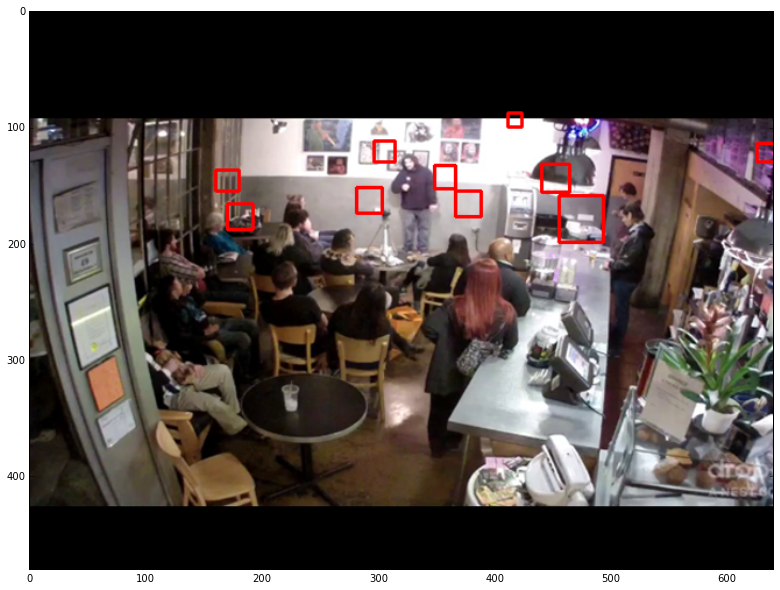

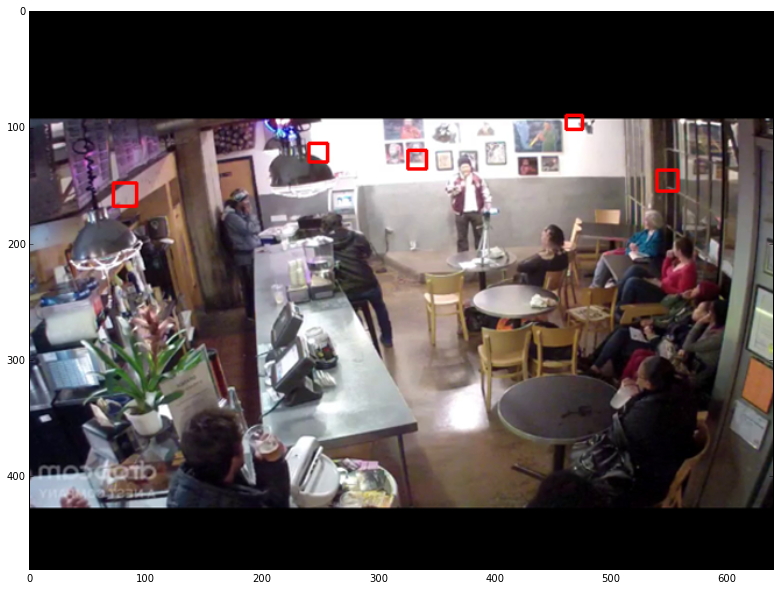

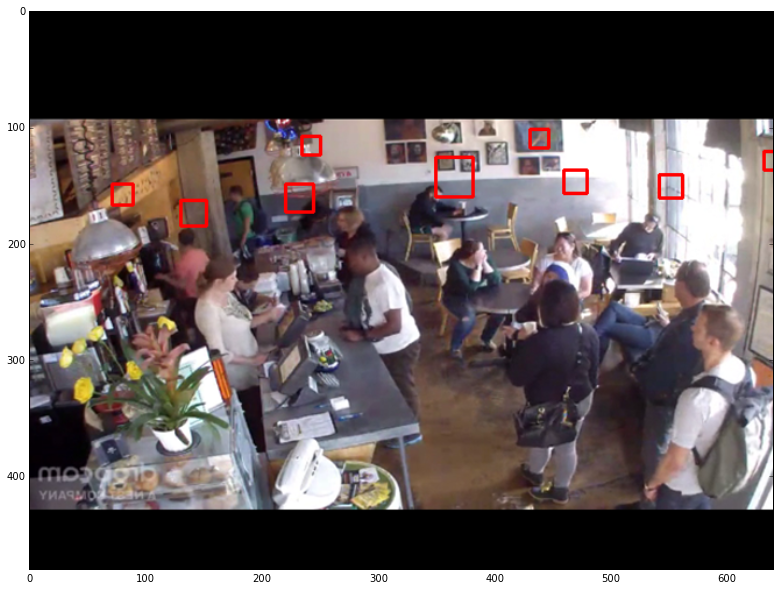

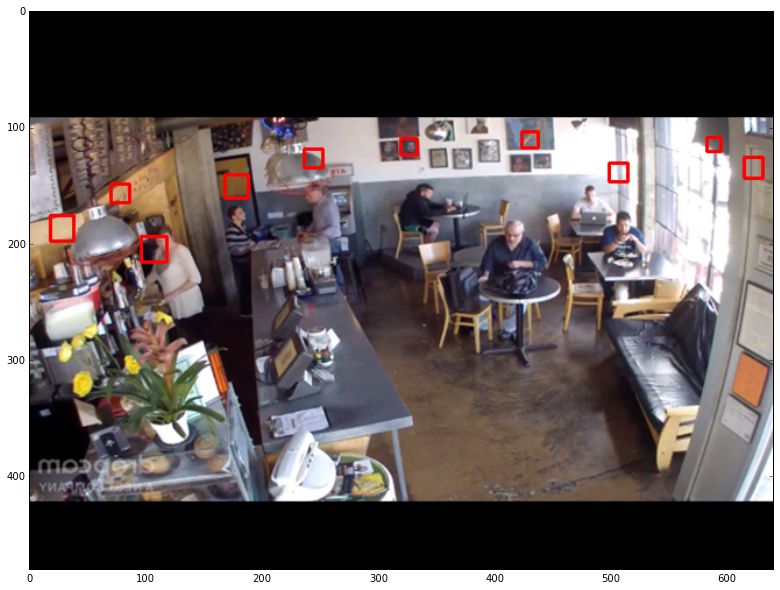

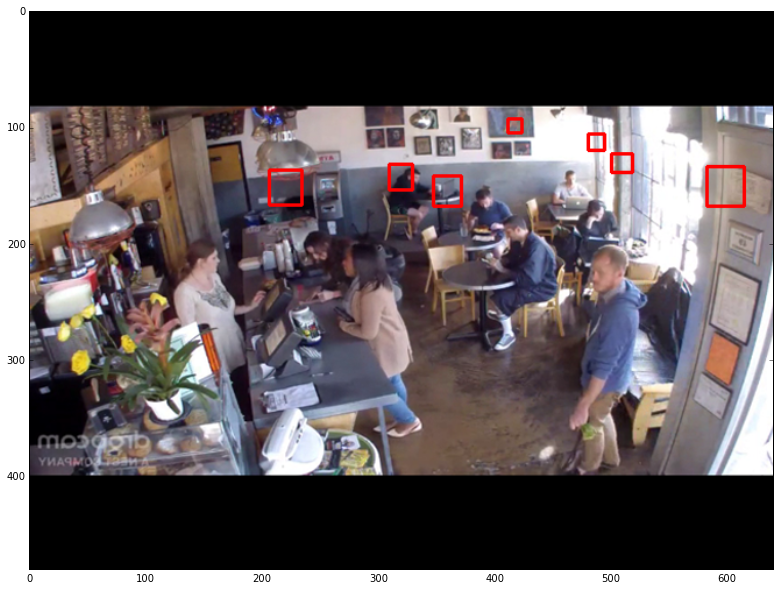

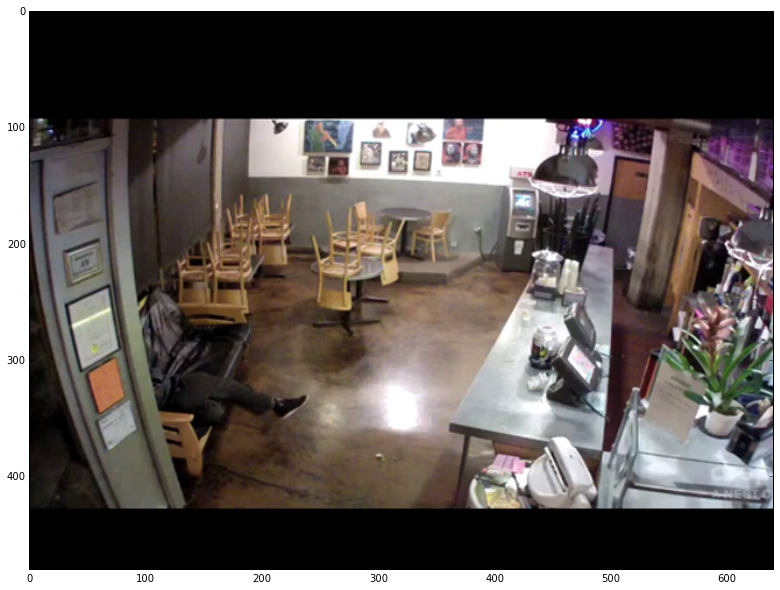

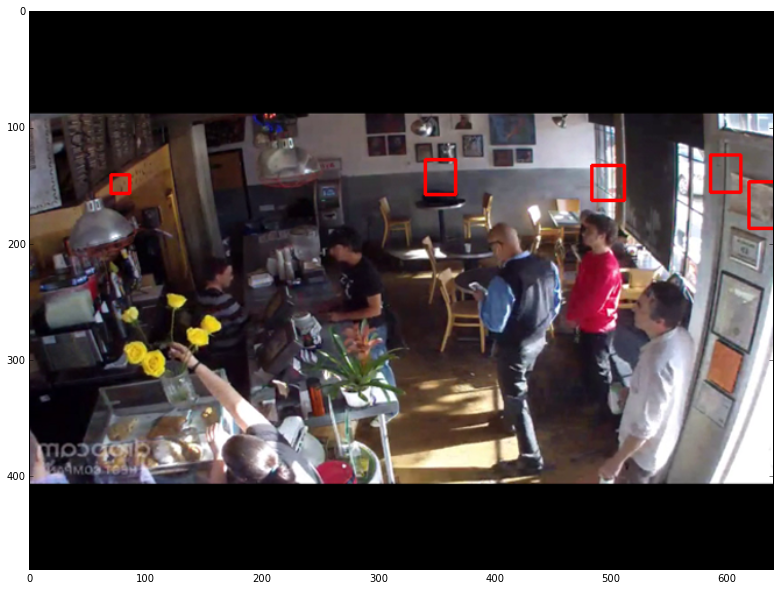

In [114]:
annolist = al.AnnoList()
net_config = config["net"]
pix_per_w = net_config["img_width"]/net_config["grid_width"]
pix_per_h = net_config["img_height"]/net_config["grid_height"]
for i in range(10):
    inputs = test_gen.next()
    bbox_list, conf_list = forward(net, inputs, net_config, True)
    
    img = inputs["raw"]
    png = inputs["imname"]
    png_img = imread(png)
#     if i % 10 == 0: print i
    all_rects = [[[] for x in range(net_config["grid_width"])] for y in range(net_config["grid_height"])]
    for n in range(len(bbox_list)):
        for k in range(net_config["grid_height"] * net_config["grid_width"]):
            y = int(k / net_config["grid_width"])
            x = int(k % net_config["grid_width"])
            bbox = bbox_list[n][k]
#             bbox = inputs["boxes"][0,k,:,n,0]
            conf = conf_list[n][k,1]
            abs_cx = pix_per_w/2 + pix_per_w*x + int(bbox[0,0,0])
            abs_cy = pix_per_h/2 + pix_per_h*y+int(bbox[1,0,0])
            w = bbox[2,0,0]
            h = bbox[3,0,0]
            if conf > 0.7:
                all_rects[y][x].append(Rect(abs_cx,abs_cy,w,h,conf - (0. * n)))
    
    acc_rects = []
    acc_rects = filter_rects(all_rects, .5, acc_rects, config=net_config)
    acc_rects = filter_rects(all_rects, .4, acc_rects, .6, config=net_config)
    acc_rects = filter_rects(all_rects, .3, acc_rects, .5, config=net_config)
    acc_rects = filter_rects(all_rects, .2, acc_rects, .4, config=net_config)
    acc_rects = filter_rects(all_rects, .1, acc_rects, .3, config=net_config)
    acc_rects = filter_rects(all_rects, .05, acc_rects, .2, config=net_config)

    accepted_rects = acc_rects
    
    display = True
    if display:
        for rect in acc_rects:
            assert rect.true_confidence <= rect.confidence
            if rect.true_confidence < 0.3:
                continue
            cv2.rectangle(img, (rect.cx-int(rect.width/2), rect.cy-int(rect.height/2)), 
                          (rect.cx+int(rect.width/2), rect.cy+int(rect.height/2)), 
                                              (255,0,0), 2)
     
        plt.figure(figsize=(15,10))
        plt.imshow(img)
        
    anno = al.Annotation()
    anno.imageName = ""
    for rect in accepted_rects:
        r = al.AnnoRect()
        scale = 1.07 if (rect.width < 50 and rect.height < 50) else 1.0
        r.x1 = rect.cx - rect.width/2.*scale
        r.x2 = rect.cx + rect.width/2.*scale
        r.y1 = rect.cy - rect.height/2.*scale
        r.y2 = rect.cy + rect.height/2.*scale
        r.score = rect.true_confidence
        anno.rects.append(r)
    annolist.append(anno)
#     if True:
#         a = gt_al_list[i]
#         for r in a.rects:
#             cx = int((r.x1 + r.x2) / 2)
#             cy = int((r.y1 + r.y2) / 2)
#             width = r.x2 - r.x1
#             height = r.y2 - r.y1
#             rect = Rect(cx, cy, width, height, r.score)
#             assert rect.true_confidence <= rect.confidence
#             cv2.rectangle(img, (rect.cx-int(rect.width/2), rect.cy-int(rect.height/2)), 
#                           (rect.cx+int(rect.width/2), rect.cy+int(rect.height/2)), 
#                                               (0,255,0), 2)

saving:  /deep/u/stewartr/reviews/kitti_val_pred.pal


AssertionError: 

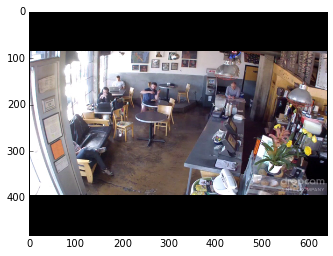

In [107]:

# annolist.save('/deep/u/stewartr/reviews/kitti_test_pred.pal')
annolist.save('/deep/u/stewartr/reviews/kitti_val_pred.pal')

In [ ]:
def pal_to_txt(pal, directory):
    subprocess.call('mkdir -p %s' % directory, shell=True)
    for anno in pal:
        records = []
        for r in anno.rects:
            records.append("Car -1 -1 -10 %d %d %d %d -1 -1 -1 -1000 -1000 -1000 -10 %.2f" % 
                           (r.x1, r.y1, r.x2, r.y2, r.score))
        out_fname = "%s/%s.txt" % (directory, anno.imageName.split('/')[-1][:6])
        with open(out_fname, 'w') as f:
            f.write('\n'.join(records))

In [ ]:
pal_to_txt(al.parse(hyper['test_pal']), '/deep/u/stewartr/apollo/eval/stewartr_label_trainval_rep')
pal_to_txt(annolist, '/deep/u/stewartr/apollo/eval/stewartr_pred_trainval_rep')

In [ ]:
print annolist[0].imageName